<a href="https://www.kaggle.com/code/vanpatangan/predict-commercial-flight-delays?scriptVersionId=203274737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings 
warnings.simplefilter('ignore')

# load data

In [2]:
# Import commercial flight data 
flights_df = pd.read_csv('/kaggle/input/bts-january-2024-commercial-flights-data/T_ONTIME_MARKETING.csv')

# Import IATA codes to identify airline names 
iata_codes_df = pd.read_excel('/kaggle/input/bts-january-2024-commercial-flights-data/Bansard-airlines-codes-IATA-ICAO.xlsx', 'All Airlines')

In [3]:
flights_df.head()

,FL_DATE,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_MARKET_ID,DEST_CITY_NAME,...,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_WHEELS_ON,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
0,1/1/2024 12:00:00 AM,AA,AA,N101NN,255,31703,"New York, NY",NY,32575,"Los Angeles, CA",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2024 12:00:00 AM,AA,AA,N101NN,32,32575,"Los Angeles, CA",CA,31703,"New York, NY",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2024 12:00:00 AM,AA,AA,N102NN,1578,30721,"Boston, MA",MA,32575,"Los Angeles, CA",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2024 12:00:00 AM,AA,AA,N102NN,1578,32575,"Los Angeles, CA",CA,30721,"Boston, MA",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/1/2024 12:00:00 AM,AA,AA,N102UW,1225,30466,"Phoenix, AZ",AZ,34057,"Portland, OR",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
iata_codes_df.head()

,IATA,ICAO,Airline
0,0A,GNT,Amber Air (Lithuania)
1,0D,DWT,Darwin Airline (Switzerland)
2,0J,JCS,Jetclub (Switzerland) Jetclub
3,0K,KRT,Kokshetau (Kazakhstan) Kokta
4,0W,WCR,West Caribbean Costa Rica (Costa Rica) West Ca...


In [7]:
# Drop the 'ICAO' column and set the 'IATA' column as the index
iata_codes_df = iata_codes_df.drop(columns='ICAO').set_index('IATA')

# Iterate over the airline column to modify its values
for i, row in iata_codes_df['Airline'].items():
    # Split the row string by the ')' character and keep the part after it
    split_row = row.split(')')
    if len(split_row) > 1:
        iata_codes_df.at[i, 'Airline'] = split_row[1].strip()

# Merge the original dataframe on the specified columns
flights_df = flights_df.merge(iata_codes_df, left_on='OP_UNIQUE_CARRIER', right_index=True, how='left')

# Rename the airline column 
flights_df.rename(columns={'Airline': 'OPERATING_AIRLINE_NAME'}, inplace=True)

# drop columns 

In [13]:

def remove_columns_with_missing_values(df, threshold=0.1):
    
    # Calculate the proportion of missing values in each column
    missing_proportion = df.isnull().mean()
    
    # Identify columns to drop (those with missing values greater than the threshold)
    columns_to_drop = missing_proportion[missing_proportion > threshold].index
    
    # Print the names of the columns that will be dropped
    print(f"Columns dropped (more than {threshold*100}% missing values): {list(columns_to_drop)}")
    
    # Identify columns to keep (those with missing values less than or equal to the threshold)
    columns_to_keep = missing_proportion[missing_proportion <= threshold].index
    
    # Return the DataFrame with only the columns to keep
    return df[columns_to_keep]

flights_df = remove_columns_with_missing_values(flights_df)

# Reset index
flights_df = flights_df.reset_index(drop=True)

Columns dropped (more than 10.0% missing values): ['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV1_AIRPORT', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_WHEELS_ON', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM']


# countplot and distribution

<Figure size 2000x2000 with 0 Axes>

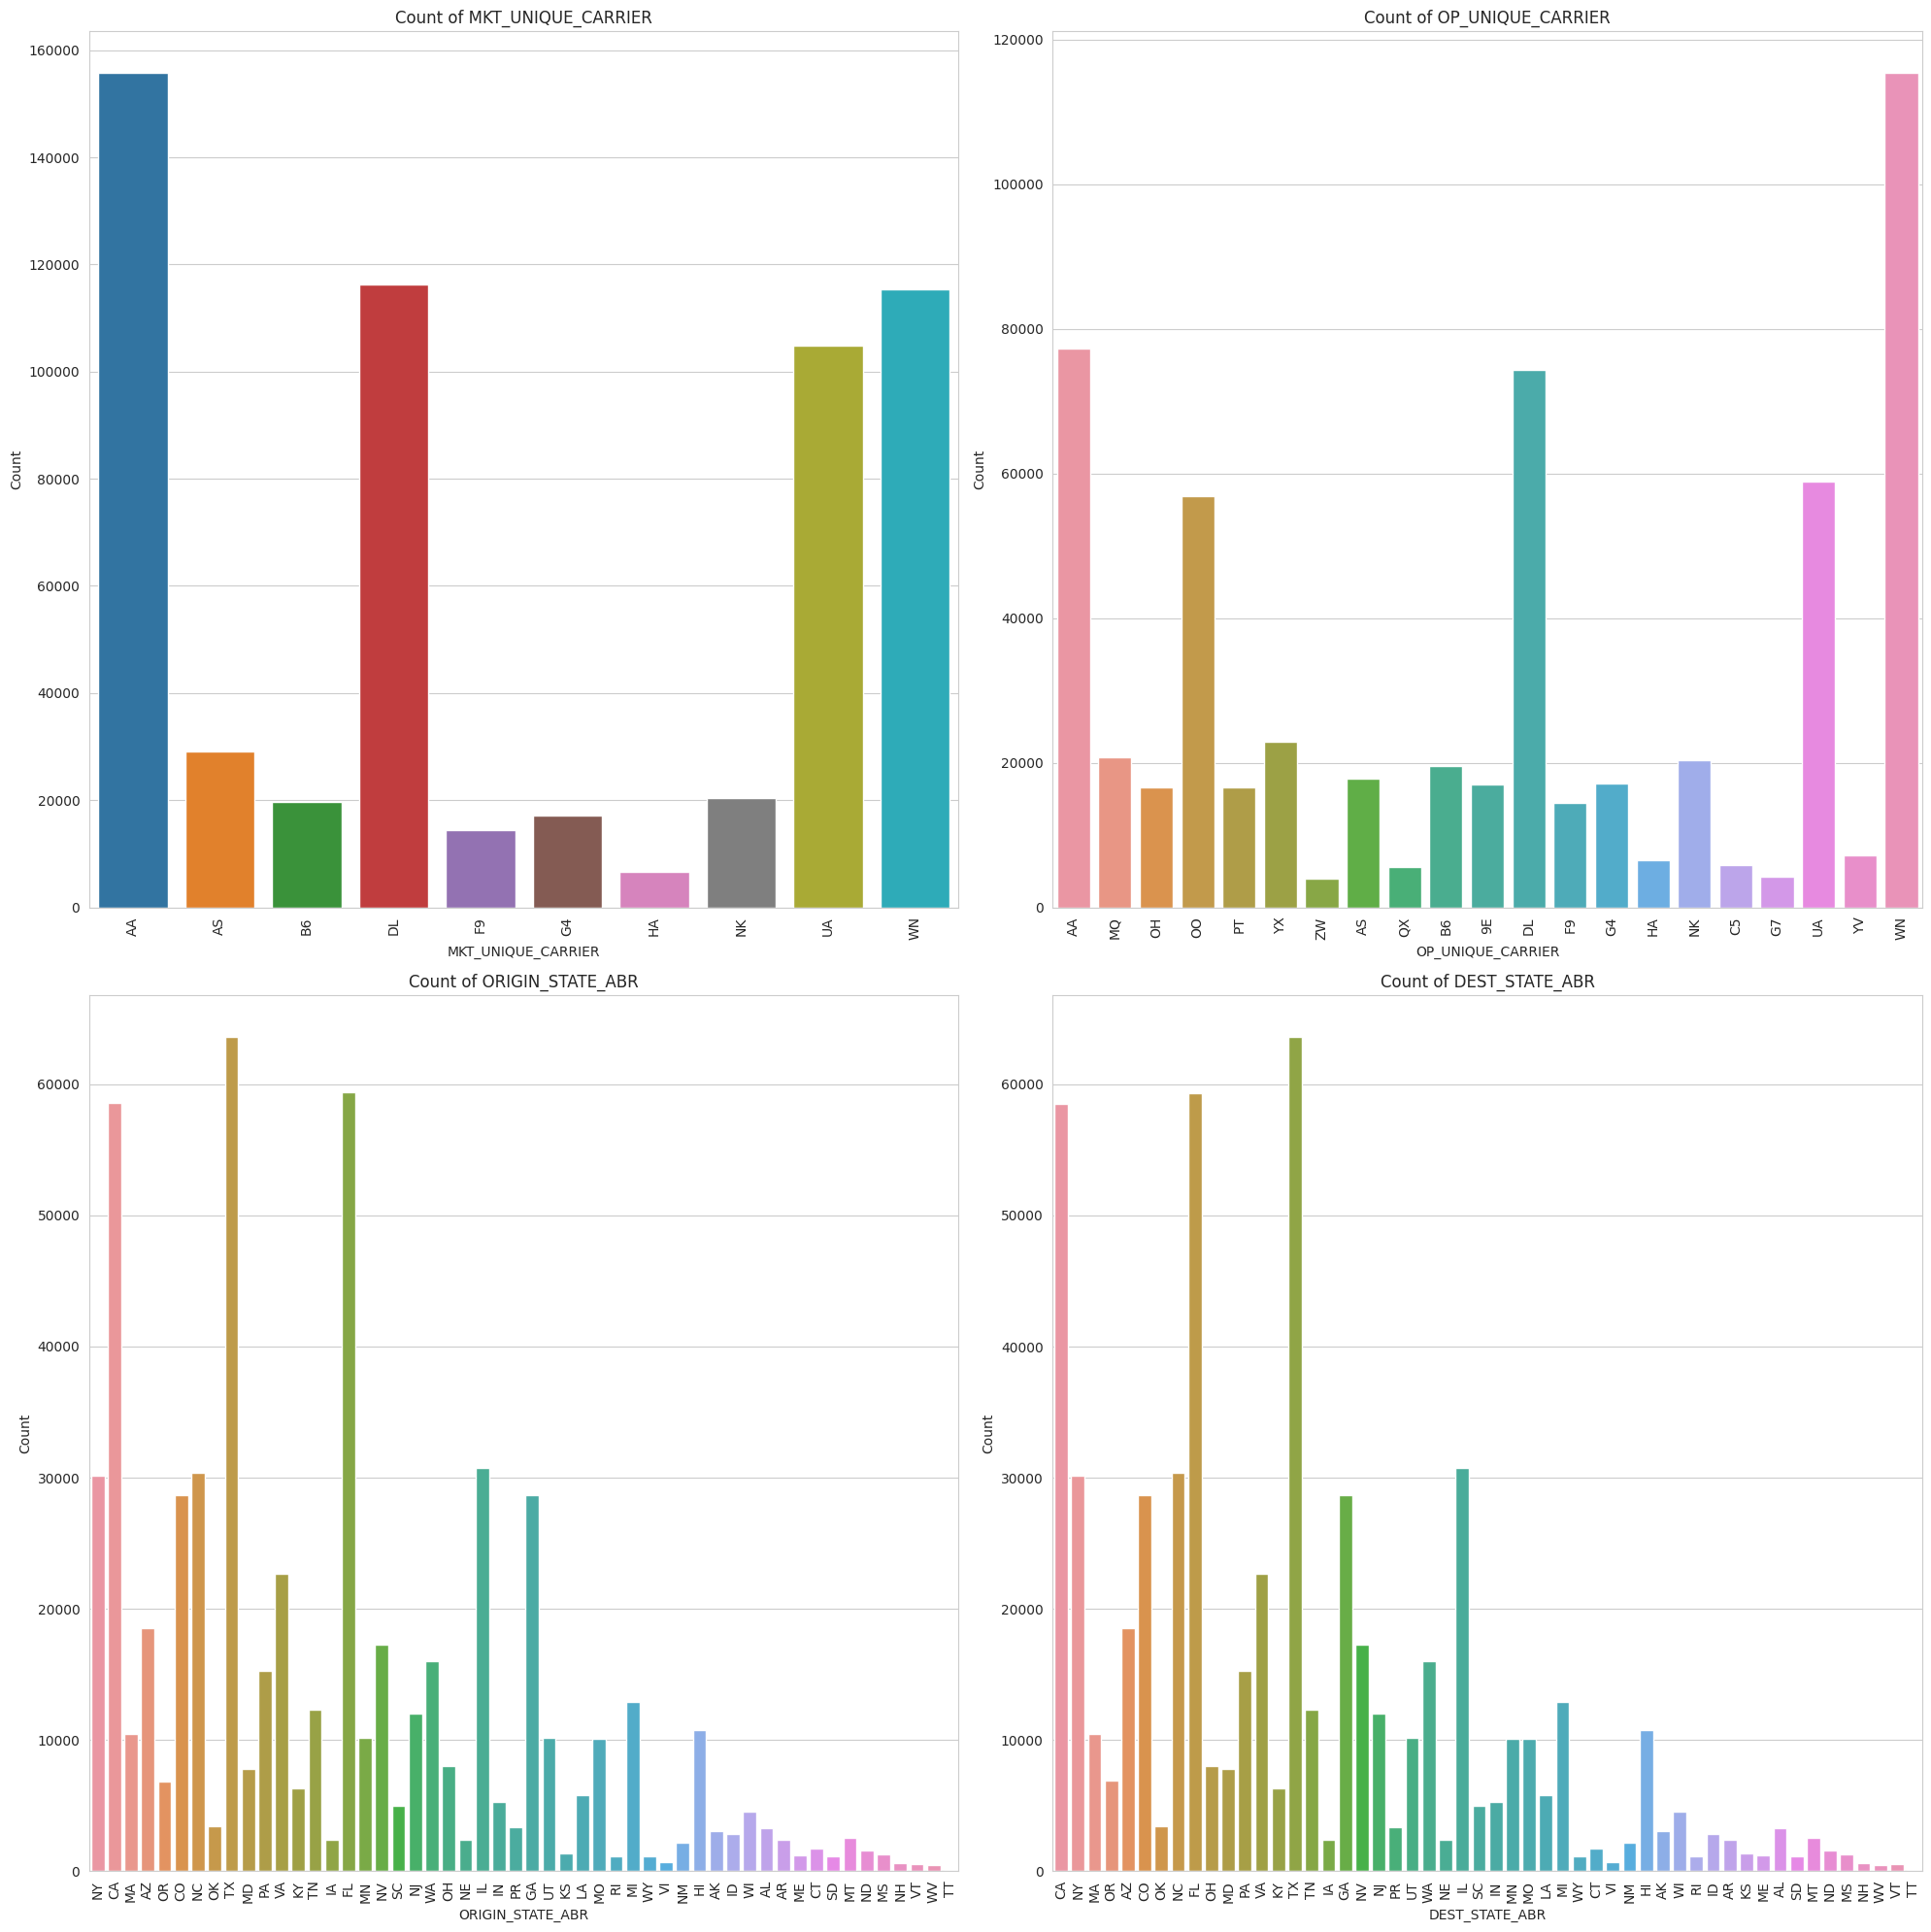

In [16]:
# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 20))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# List of columns to plot
columns = ['MKT_UNIQUE_CARRIER', 'OP_UNIQUE_CARRIER', 'ORIGIN_STATE_ABR', 'DEST_STATE_ABR']

# Create countplots
for i, column in enumerate(columns):
    sns.countplot(data=flights_df, x=column, ax=axes[i])
    axes[i].set_title(f'Count of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    
    # Rotate x-axis labels if they're too crowded
    axes[i].tick_params(axis='x', rotation=90)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

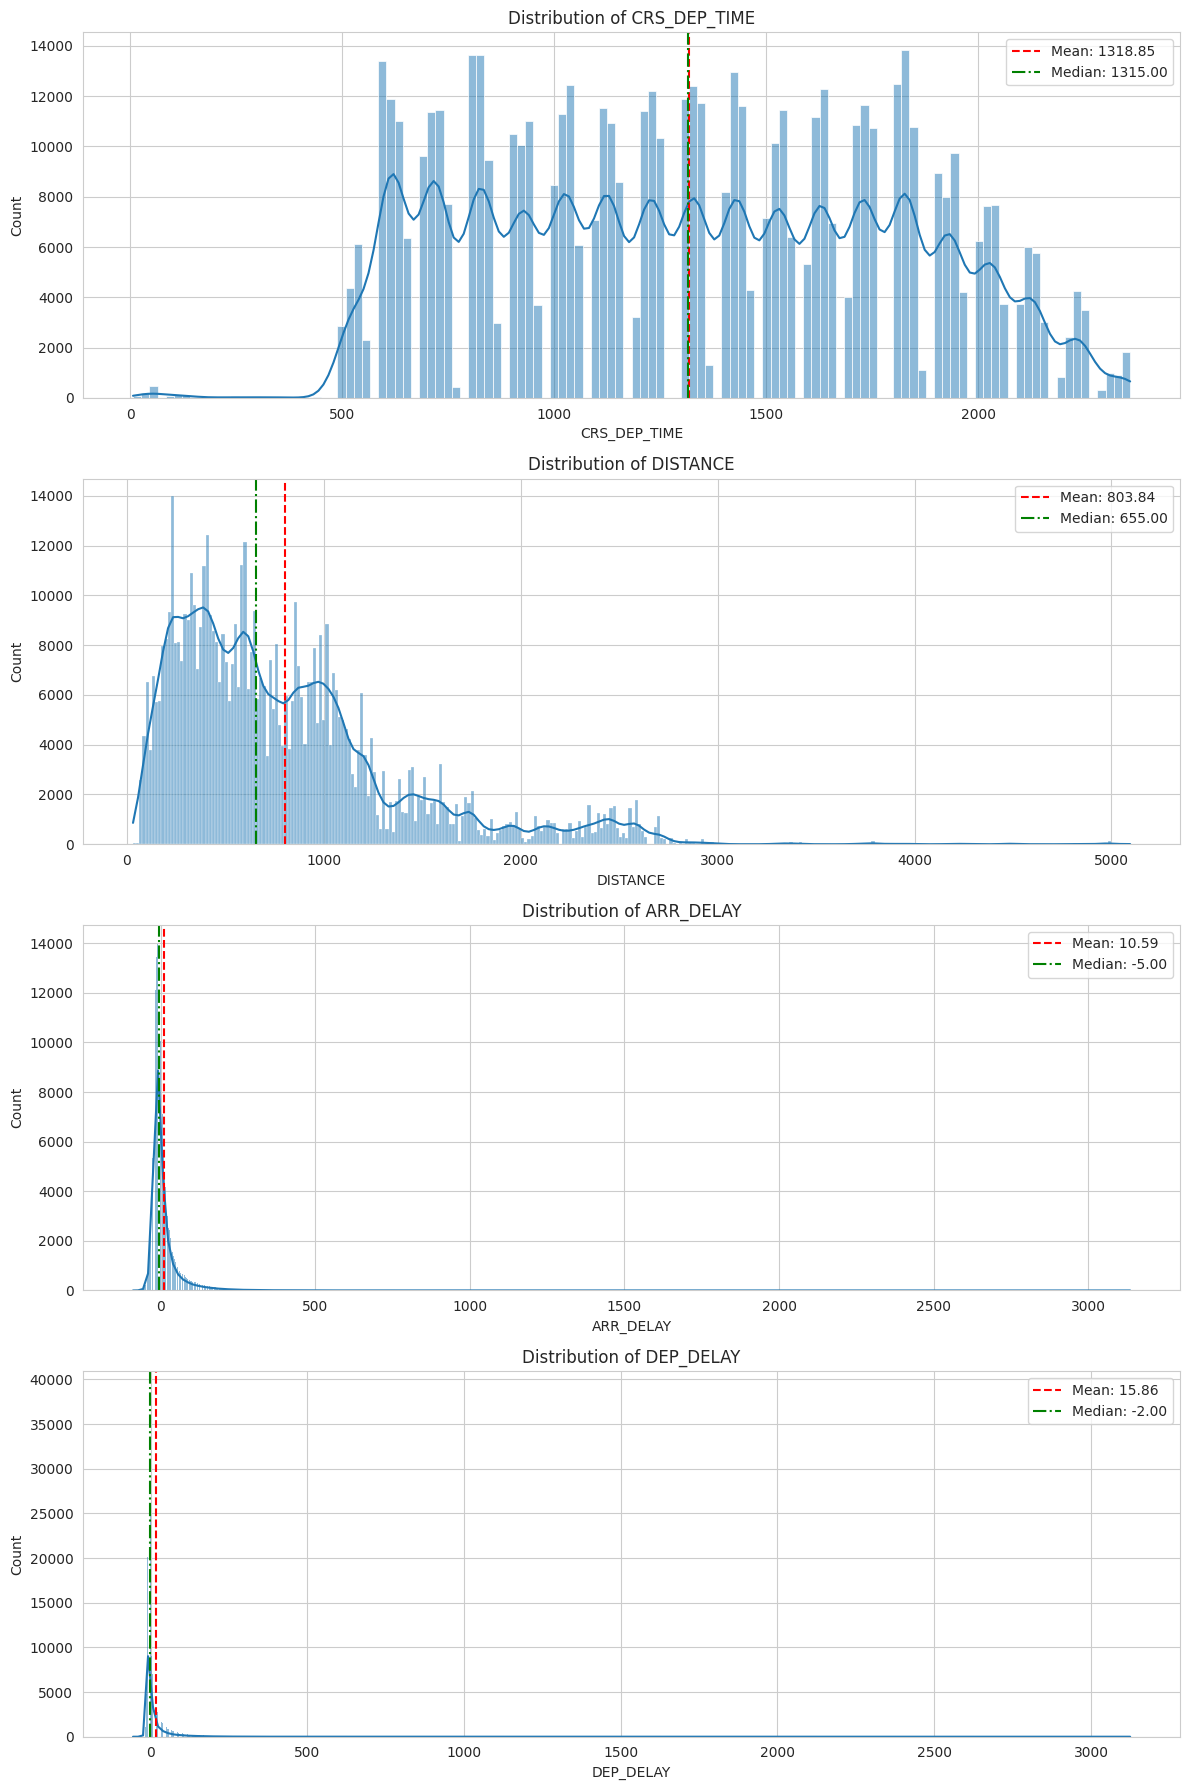

In [17]:
# Set up the plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 18))

# List of columns to visualize
columns = ['CRS_DEP_TIME', 'DISTANCE', 'ARR_DELAY', 'DEP_DELAY']

# Create distribution plots
for i, column in enumerate(columns):
    sns.histplot(data=flights_df, x=column, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

    # Add mean and median lines
    mean = flights_df[column].mean()
    median = flights_df[column].median()
    axes[i].axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    axes[i].axvline(median, color='g', linestyle='-.', label=f'Median: {median:.2f}')
    axes[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# preprocessing

In [18]:
# Replace NaN with 0 for numeric columns and 'unknown' for categorical columns
flights_df = flights_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('unknown'))

data = flights_df.copy(deep=True)

In [19]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])  

In [20]:
from sklearn.preprocessing import StandardScaler

# Feature engineering
data['FL_DATE'] = pd.to_datetime(data['FL_DATE'])
data['day_of_week'] = data['FL_DATE'].dt.dayofweek
data['month'] = data['FL_DATE'].dt.month
data['hour'] = data['CRS_DEP_TIME'] // 100

# Define features and target
X = data.drop(columns=['FL_DATE', 'DEP_DELAY'])
y = data['DEP_DELAY']

# Scale numerical features
scaler = StandardScaler()
X[['CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'DISTANCE']] = scaler.fit_transform(X[['CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'DISTANCE']])

# modeling

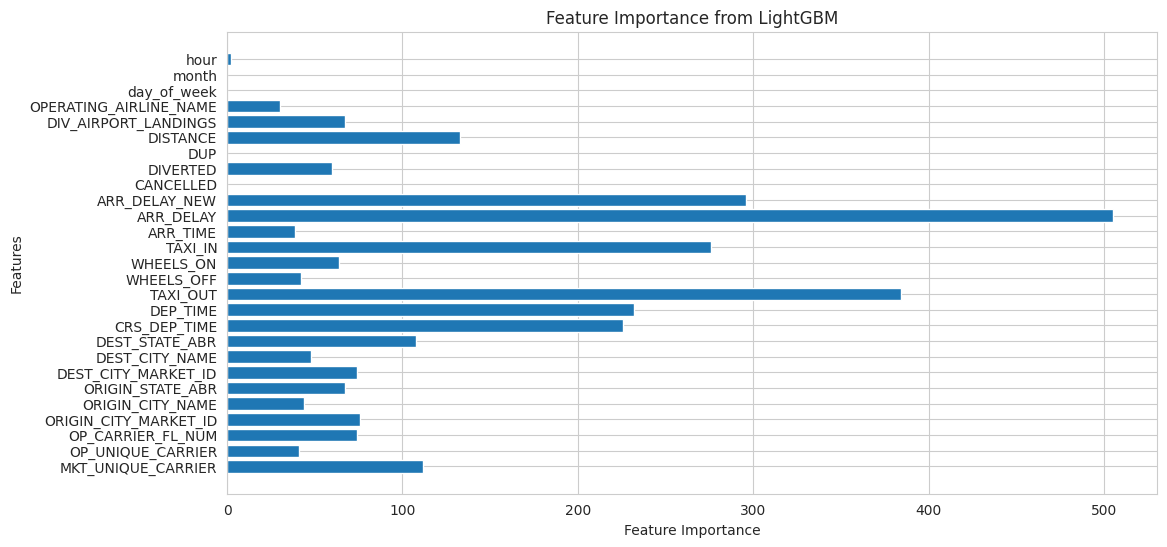

Cross-validated MAE: 5.131497601975238


In [21]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE

# Define features and target
X = data.drop(columns=['FL_DATE', 'DEP_DELAY','TAIL_NUM'])  # Drop target and non-relevant columns
y = data['DEP_DELAY']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=0)
lgb_model.fit(X_train, y_train)

# Get feature importance
feature_importance = lgb_model.feature_importances_
features = X_train.columns

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM')
plt.show()

# Perform RFE
rfe = RFE(lgb_model, n_features_to_select=10, verbose=0)  # Adjust the number of features to select
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Train and evaluate model with selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

lgb_model_rfe = lgb.LGBMRegressor(verbose=0)
lgb_model_rfe.fit(X_train_rfe, y_train)

# Evaluate model
scores = cross_val_score(lgb_model_rfe, X_train_rfe, y_train, cv=5, scoring='neg_mean_absolute_error')
print('Cross-validated MAE:', -scores.mean())

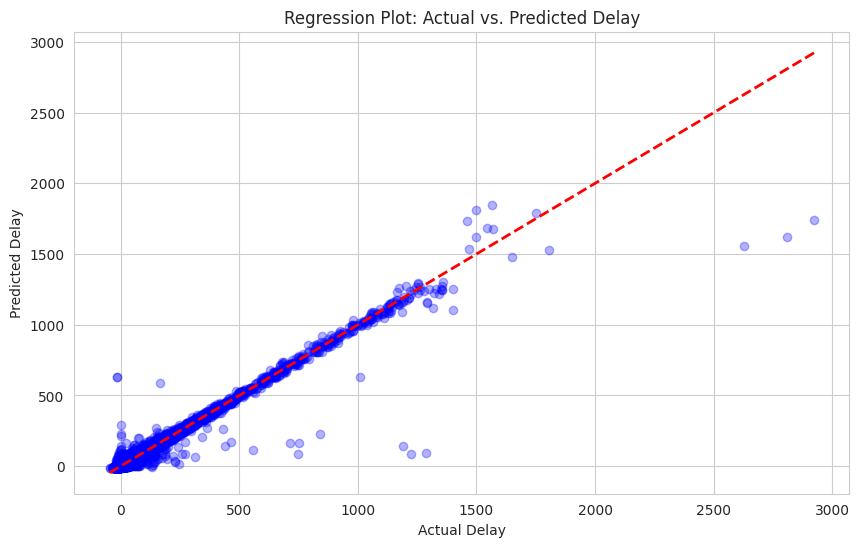

In [22]:
# Predict on test set with selected features
y_pred = lgb_model_rfe.predict(X_test_rfe)

# Plot regression chart: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')
plt.title('Regression Plot: Actual vs. Predicted Delay')
plt.show()

# prophet

07:49:06 - cmdstanpy - INFO - Chain [1] start processing
07:54:34 - cmdstanpy - INFO - Chain [1] done processing


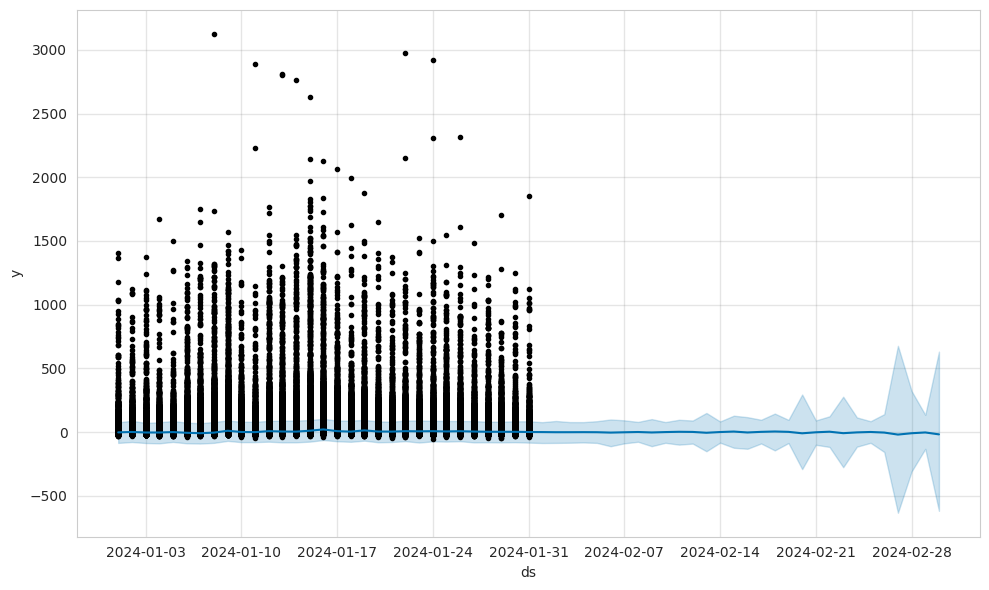

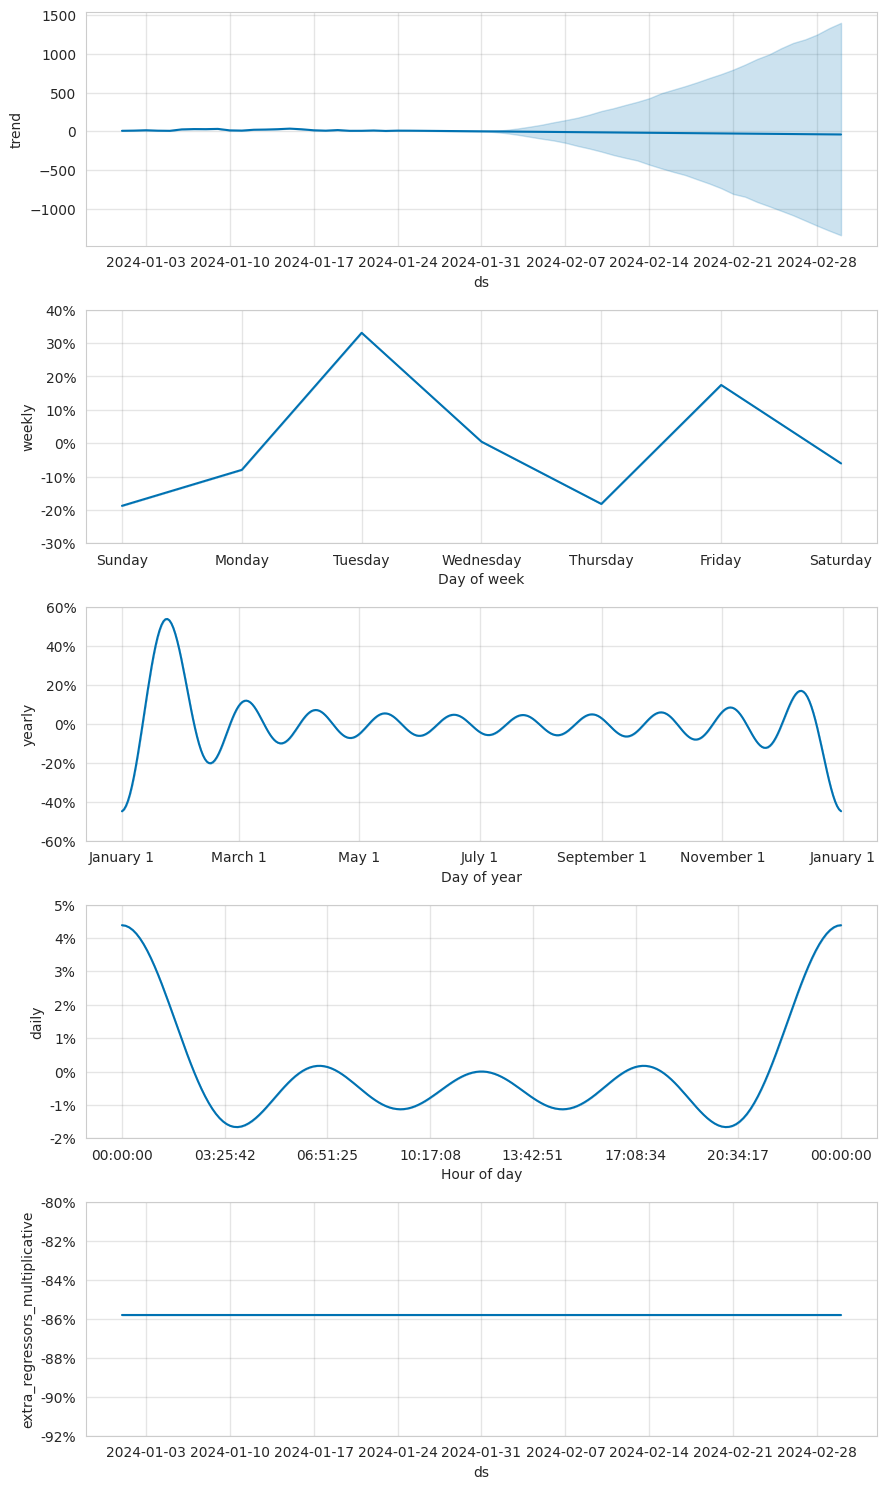

In [23]:
from prophet import Prophet

# Rename columns for Prophet
flights_df = flights_df.rename(columns={'FL_DATE': 'ds', 'DEP_DELAY': 'y'})

# Select relevant columns and drop rows with NaN values in 'ds' and 'y'
prophet_df = flights_df[['ds', 'y', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DISTANCE']].dropna(subset=['ds', 'y'])

# Convert categorical features to dummy variables
prophet_df = pd.get_dummies(prophet_df, columns=['ORIGIN_CITY_NAME', 'DEST_CITY_NAME'])

# Initialize the Prophet model with some tuning
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0,
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True
)

# Add additional regressors
model.add_regressor('CRS_DEP_TIME')
model.add_regressor('DISTANCE')

# Fit the model on your data
model.fit(prophet_df)

# Create a DataFrame with future dates
future_dates = model.make_future_dataframe(periods=30) #monthly

# Include the regressors in the future dates DataFrame
# Ensure to set dummy columns for future dates as well
future_dates = pd.concat([future_dates, pd.DataFrame(columns=prophet_df.columns.drop(['ds', 'y']))]).fillna(0)

# Make predictions
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
fig.show()

# Plot the components
fig_components = model.plot_components(forecast)
fig_components.show()